In [143]:
import requests
import os
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import pandas as pd
import math
import datetime
import numpy as np


In [46]:
## READ .env

# Load environment variables from file .env
dotenv_path = os.path.join('PRIVATE', '.env')
load_dotenv(dotenv_path)

# Construct the payload using environment variables
payload = {
    'client_id': os.getenv('CLIENT_ID'),
    'client_secret': os.getenv('CLIENT_SECRET'),
    'refresh_token': os.getenv('REFRESH_TOKEN'),
    'grant_type': "refresh_token",
    'f': 'json'
}

In [68]:
auth_url = "https://www.strava.com/oauth/token"   # URL for requesting authorization token from Strava
activites_url = "https://www.strava.com/api/v3/athlete/activities"   # URL for retrieving activities data from Strava API

# Sending a request to Strava to obtain permission
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']

header = {'Authorization': 'Bearer ' + access_token}   # Constructing the header with the access token for authorization

# Setting parameters for the request to retrieve activities data
param = {'per_page': 200, 'page': 1}
data = requests.get(activites_url, headers=header, params=param).json()

file_path = "data.json"
with open(file_path, 'w') as file:
    json.dump(data, file)

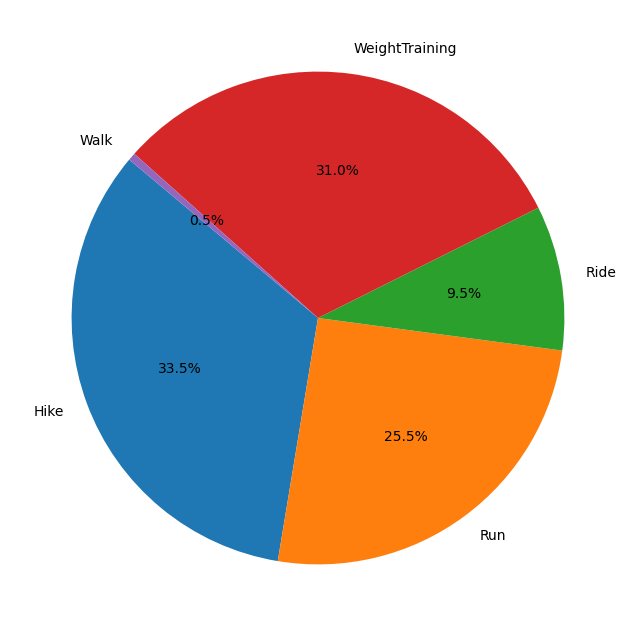

In [82]:
# I want to take all activities by type and see the history which activity I did the most
f = open('data.json')
data = json.load(f)

list_activity = []
for i in range(0, len(data)):
    list_activity.append(data[i]['type'])

activity_counts = Counter(list_activity)
activities = list(activity_counts.keys())
frequencies = list(activity_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(frequencies, labels=activities, autopct='%1.1f%%', startangle=140)
plt.show()

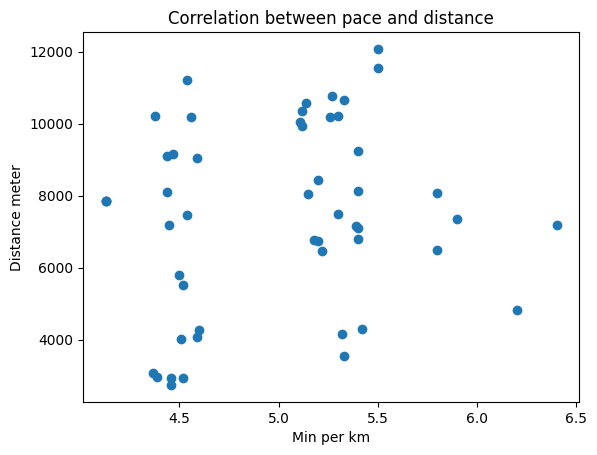

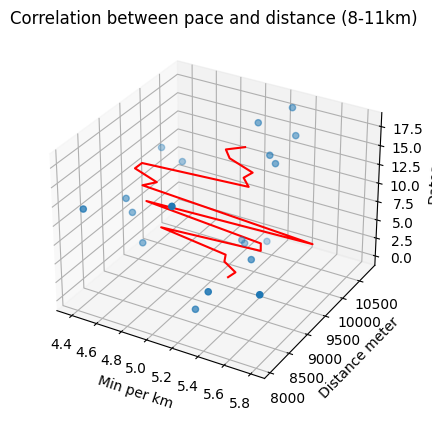

In [144]:
# My focus will be on running 
# I want to know average of km done in a session (there's no average time in downloaded data)
'''
IDEA:

moving_time = 2705 
distance = 8445.9

pace_km_sec = 2705/8,45 = 320,12
pace_km_min = 320,12 / 60 = 5,34
seconds = 0,34 * 60 = 20,4
pace_km = 5,20
'''

run_activities = []   # List to store only the run activities

# Filter the data to get only the run activities
for activity in data:
    if activity['type'] == 'Run':
        run_activities.append(activity)

activities = []   # List to store processed run activities

# Process each run
for run in run_activities:
    
    # Combine minutes and seconds to get pace per kilometer
    pace_km_sec = run['moving_time']/(run['distance']/1000)
    pace_km_min = pace_km_sec / 60 
    frac, whole = math.modf(pace_km_min)
    seconds = frac * 60 
    min_per_km = float(f"{whole:.0f}.{seconds:.0f}")
    
    if min_per_km<10 :    #there's 2 activity with a strange min_km (>16min/km) quite impossible
        # Create a dictionary for the processed run activity
        activity = {
            'name': run['name'],
            'distance': run['distance'],
            'moving_time': run['moving_time'],
            'min_km': min_per_km,
            'type': run['type'],
            'id': run['id'],
            'start_date': run['start_date'],
            'map': run['map']
        }

    # Add the processed run activity to the list of activities
    activities.append(activity)
       
# now i want to plot pace per km based on distance run
x = [activity['min_km'] for activity in activities]
y = [activity['distance'] for activity in activities]

plt.scatter(x, y)
plt.xlabel('Min per km')
plt.ylabel('Distance meter')
plt.title('Correlation between pace and distance')
plt.show()

# now i want to plot pace per km based on distance run between 8 and 11 km
selected_activities = [activity for activity in activities if 8000 <= activity['distance'] < 11000]

x = [activity['min_km'] for activity in selected_activities]
y = [activity['distance'] for activity in selected_activities]
z = range(len(selected_activities))  
dates = [datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ") for activity in selected_activities]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

coefficients = np.polyfit(x, y, 1) 
polynomial = np.poly1d(coefficients)

y_regression = polynomial(x)

ax.plot(x, y_regression, z, color='red')

ax.set_xlabel('Min per km')
ax.set_ylabel('Distance meter')
ax.set_zlabel('Dates')
ax.set_title('Correlation between pace and distance (8-11km)')
plt.show()